In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.stats import norm
from sklearn.covariance import EllipticEnvelope

%matplotlib inline

# 1.  Deteção de Anomalias

Nesta seção, foi implementado um algoritmo de **Detecção de Anomalia** para detectar comportamentos anômalos nos servidores de um _Datacenter_. As características medem o $Fluxo$ $de$ $dados$ (_throughput_ em $10^{6}$ bytes por segundos) e $Tempo$ $de$ $resposta$ (_latency_ em $10^{-6}$ segundos) de cada servidor. 

Enquanto os servidores estavam funcionando, foram coletados `m = 307` exemplos de como eles estavam se comportando. Sobretudo, acredita-se que a grande maioria desses exemplos são _”normais”_(**não anômalos**) dos servidores que operam normalmente, mas também podem haver alguns exemplos de servidores que atuam de forma _anômala_ nesse conjunto de dados.

Para tal finalidade será usado um *Modelo Gaussiano* para detectar **exemplos anômalos** nesse conjunto de dados. Esse  conjunto de dados 2D permitirá a visualização do que o algoritmo está fazendo. Além isso, será ajustada a **Distribuição Gaussiana** a fim de que valores que possuem probabilidade muito baixa sejam identificados como anomalias.


In [2]:
data = pd.Series(loadmat('am-T2-dados/ex8data1.mat'))
data.keys()

Index(['X', 'Xval', '__globals__', '__header__', '__version__', 'yval'], dtype='object')

In [3]:
data

X              [[13.0468151687, 14.7411524132], [13.408520185...
Xval           [[15.7902597926, 14.9210243032], [13.639618767...
__globals__                                                   []
__header__     b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                  1.0
yval           [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...
dtype: object

In [4]:
# Removendo Labels de arquivo Matlab do DATASET

data = data.drop('__globals__')
data = data.drop('__header__')
data = data.drop('__version__')
data

X       [[13.0468151687, 14.7411524132], [13.408520185...
Xval    [[15.7902597926, 14.9210243032], [13.639618767...
yval    [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...
dtype: object

In [5]:
X_serie = data['X']
Xval = data['Xval']
yval = data['yval']

print(X_serie.shape)
print(Xval.shape)
print(yval.shape)

(307, 2)
(307, 2)
(307, 1)


# 1.1 Distribuição Gaussiana

Para realizar a detecção de anomalia, precisaremos primeiro ajustar um modelo a distribuição dos dados.
Dado um conjunto de treinamento $\large {x^{(1)}, . . . , x^{(m)} }$, onde $\large x^{(i)} ∈ R^{n}$, devemos estimar a **Distribuição Gaussiana** para cada uma das características $X_{j}$. Para cada característica $j = 1, . . . , n$, você precisa encontrar os parâmetros $\large \mu_{j}$ e $\large \sigma_{j}^{2}$ que se encaixam nos dados na **`j-ésima`** dimensão $x(1),...,x(m)$.

# 1.2 Estimativa de parâmetros para uma gaussiana

Você pode estimar os parâmetros, $\large (\mu_{j}$, $\large \sigma_{j}^2)\large$, da j-ésima característica usando as equações apresentadas em aula.
Sua tarefa é implementar código em um arquivo de nome **estimativaGaussian.py**, que deve conter uma função de mesmo nome. Esta função toma como entrada a matriz de dados X e deve produzir um vetor de dimensão N $\large \mu$ que contém a média de todas as características N e outro vetor de dimensão N $\large sigma2$ que contém as variâncias de todas as características.

In [6]:
def estimativaGaussian(X):  
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    return mu, sigma

Após completado o código em **estimativaGaussian.py**, a próxima tarefa será visualizar os contornos da `Distribuição Gaussiana` ajustada, obteremos um gráfico semelhante a _Figura abaixo_. Nessa figura, vemos que a maioria dos exemplos está na região de maior probabilidade, enquanto os exemplos anômalos estão nas regiões de probabilidades menores.

In [7]:
mu, sigma = estimativaGaussian(X_serie)  
print(mu)
print(sigma)

[ 14.11222578  14.99771051]
[ 1.83263141  1.70974533]


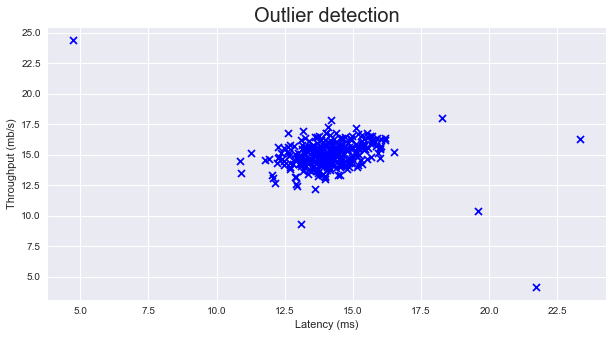

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(X_serie[:,0], X_serie[:,1], c='b', marker='x')
plt.title("Outlier detection", fontsize=20)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

# 1.3 Selecionando $\epsilon$

Agora vamos investigar quais exemplos têm uma probabilidade muito alta dada essa distribuição e quais
exemplos têm uma probabilidade muito baixa. Os exemplos de baixa probabilidade são mais prováveis de ser as anomalias em nosso conjunto de dados. 

Uma maneira de determinar quais exemplos são anomalias é selecionar um limite $\epsilon$ com base em um conjunto de **Validação cruzada**. Nesta parte do trabalho será implementado um algoritmo para selecionar o limite $\epsilon$ usando a medida F1 em um conjunto de **Validação cruzada**. Implementaremos o código em um arquivo de nome **selectThreshold.py**. Para isso, use um conjunto de validação cruzada $\large \{{(x_{cv}^{(1)},y_{cv}^{(1)}),... ,x_{cv}^{(m)},y_{cv}^{(m)})}\}$, onde o rótulo $y = 1$ corresponde a um
exemplo anômalo. Para cada exemplo no conjunto de validação, devemos computar $\large Pr(x(i))$. O vetor de todas essas probabilidades $\large Pr(x(1)),... ,Pr(x(mcv))$, assim como os rótulos correspondentes, devem ser passados a função implementada em **selectThreshold.py**.
A função `selectThreshold.py` deve retornar dois valores: 
 - 1º) No limite selecionado $\large \epsilon$, se um exemplo x tiver uma baixa probabilidade $\large Pr(x) < \epsilon$, então é considerado **anomalia**.
     
 - 2º) A pontuação $\large F1$ indica o quão bom está sendo realizada a tarefa de encontrar as anomalias, dado um **determinado limite**.

In [53]:
def selectThreshold(pval, yval):  
    
    EPSILON = 0
    F1 = 0
    f1 = 0

    step = ((pval.max() - pval.min()) / 1000).astype(float)

    for epsilon in np.arange(pval.min(), pval.max(), step):
        
        P = pval < epsilon
        tp = np.sum(np.logical_and(P == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(P == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(P == 0, yval == 1)).astype(float)

        prec = ( tp / (tp + fp) ).astype(float)
        rec = ( tp / (tp + fn) ).astype(float)
        f1 = (2 * prec * rec) / (prec + rec)

        if f1 > F1:
            F1 = f1
            EPSILON = epsilon

    return EPSILON, F1 

### Testando a Função selectThreshold

In [10]:
# Iniciando a Normalização p/ encontrar a PDF dos valores gerados na Estimativa Gaussiana

dist = norm(mu[0], sigma[0])  
dist.pdf(X_serie[:,0])[0:50]

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

In [11]:

P = np.zeros((X_serie.shape[0], X_serie.shape[1]))  
P[:,0] = norm(mu[0], sigma[0]).pdf(X_serie[:,0])  
P[:,1] = norm(mu[1], sigma[1]).pdf(X_serie[:,1])

In [12]:
P_val = np.zeros((X_serie.shape[0], X_serie.shape[1]))  
P_val[:,0] = norm(mu[0], sigma[0]).pdf(Xval[:,0])  
P_val[:,1] = norm(mu[1], sigma[1]).pdf(Xval[:,1])

In [13]:
epsilon, f1 = selectThreshold(P_val, yval) 
epsilon, f1 

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


(0.0095667060059568421, 0.7142857142857143)

In [14]:
outliers = np.where(P < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

### Gráfico de Dispersão com Outliers em  $\color{red}{Destaque} $

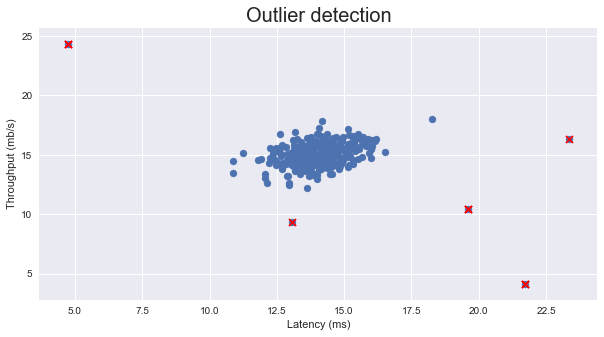

In [15]:
### Visualização Gráfica com os Outliers
plt.figure(figsize=(10,5))
plt.scatter(X_serie[:,0], X_serie[:,1])
plt.scatter(X_serie[outliers[0],0], X_serie[outliers[0],1], s=50, color='r', marker='x')
plt.title("Outlier detection", fontsize=20)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

### Definindo a Fronteira de Decisão a partir do Modelo de Envelope Elíptico

    É importante mencionar que é o Modelo de Envelope Elíptico, o qual tem a finalidade identificar outliers num conjunto de dados que esteja sob uma Distribuição Gaussiana.

In [16]:
# Construindo um Formato de Fronteira de Decisão a partir do Modelo de Envelope Elíptico.
# Para isso, é necessário fitar o dataset no Modelo EllipticEnvelope.

clf = EllipticEnvelope()
clf.fit(X_serie)

XF, YF = np.meshgrid(np.linspace(0, 25, 200), np.linspace(0, 30, 200))
ZF = clf.decision_function(np.c_[XF.ravel(), YF.ravel()])
ZF = ZF.reshape(XF.shape)

print(XF.shape)
print(YF.shape)
print(ZF.shape)

(200, 200)
(200, 200)
(200, 200)


### Gráfico de Dispersão com Outliers em  $\color{red}{Destaque}$ e $\color{red}{Fronteira}$ de Decisão

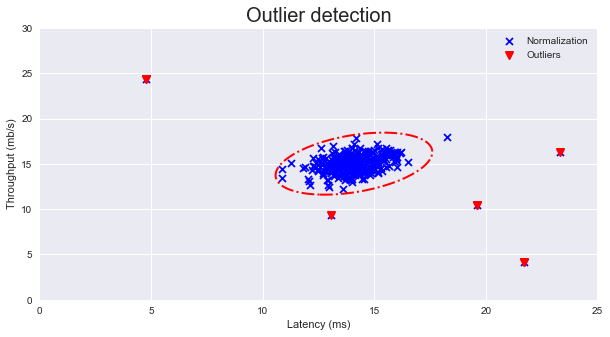

In [17]:
# Plotando os OUTLIERS
plt.figure(figsize=(10,5))
plt.scatter(X_serie[:,0], X_serie[:,1], c='b', marker='x', linewidths=4, label='Normalization')
plt.scatter(X_serie[outliers[0],0], X_serie[outliers[0],1], c='r', marker='v', linewidths=2, label='Outliers')

# Plotando a Fronteira de Decisão com base no THRESHOLD
ZT = clf.decision_function(X_serie).ravel()
threshold = np.percentile(ZT, 1.9)
plt.contour(XF, YF, ZF, levels=[threshold], linewidths=2, colors='red', linestyles='dashdot', label='Threshold')
plt.title("Outlier detection", fontsize=20)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.legend(loc=1);

### Histograma de Distribuição com $\color{blue}{Threshold}$

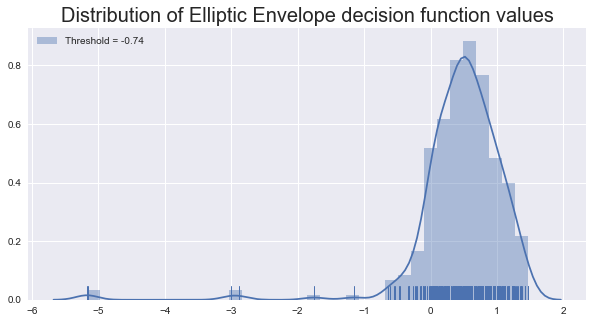

In [57]:
plt.figure(figsize=(10,5))
sns.distplot(ZT, rug=True, label='Threshold = ' +str(threshold.round(2)) )
plt.title('Distribution of Elliptic Envelope decision function values', fontsize=20)
plt.legend(loc=2);

# 2. Sistemas de Recomendação

Nesta parte, implementamos o algoritmo de aprendizagem de filtragem colaborativa e aplicando a um conjunto de dados de avaliações de filmes. Este conjunto de dados consiste em classificações em uma escala de 1 a 5. O conjunto de dados tem $NU$ = 943 usuários e $NM$ = 1682 filmes. O arquivo que contém o conjunto de dados tem nome **ex8movies.mat**, e contém as variáveis $Y$ e $R$.


In [35]:
# Carregando o arquivo Matlab para Python

dataMovie = pd.Series(loadmat('am-T2-dados/ex8_movies.mat'))
dataMovie

R              [[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,...
Y              [[5, 4, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 3, 0, 1,...
__globals__                                                   []
__header__     b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                  1.0
dtype: object

In [36]:
# Removendo Labels de arquivo Matlab do DATASET

dataMovie = dataMovie.drop('__globals__')
dataMovie = dataMovie.drop('__header__')
dataMovie = dataMovie.drop('__version__')
dataMovie

R    [[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,...
Y    [[5, 4, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 3, 0, 1,...
dtype: object

In [37]:
Y = dataMovie['Y']
R = dataMovie['R']
print('Y:', Y.shape)
print('R:', R.shape)

Y: (1682, 943)
R: (1682, 943)


### Gráfico de Dispersão do Dataset de classificação

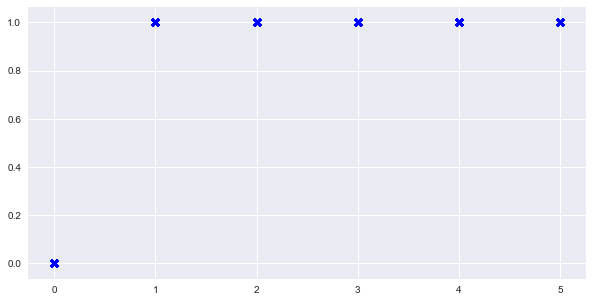

In [38]:
plt.figure(figsize=(10,5))
plt.scatter(Y, R, c='b', marker='x');

### Visualização da Matriz de Classificação dos Filmes

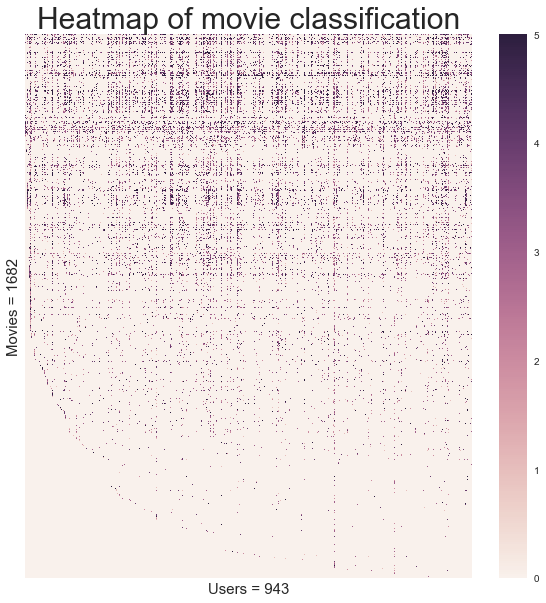

In [39]:
# Mapa de Calor para Representar a Classificação de Filmes 

plt.figure(figsize=(10,10))
sns.heatmap(Y, yticklabels=False, xticklabels=False)
plt.title('Heatmap of movie classification', fontsize=30)
plt.ylabel('Movies = '+str(1682), fontsize=15)
plt.xlabel('Users = '+str(943), fontsize=15);

# 2.1 Conjunto de dados de classificações de filme

A matriz $Y$ (Número de filmes X Número de usuários) armazena as classificações $y(i,j)$ (de 1 a 5). A matriz $R$ é uma matriz de indicadores de valor binário, onde $R(i, j)$ = 1 se o usuário $j$ forneceu uma classificacão para o filme $i$ e $R(i, j)$ = 0 em caso contrário. O objetivo da filtragem colaborativa é prever as classificacões de filmes para os filmes que os usuários ainda não classificaram, ou seja, as entradas com $R(i, j)$ = 0. Isso permitirá recomendar os filmes com classificações mais altas previstas para outros usuários.

Ao longo desta parte, você também estará trabalhando com as matrizes $X$ e $\theta$. Essas variáveis se encontram no arquivo **ex8movieParams.mat**. A _i-ésima_ linha de $X$ corresponde ao vetor de característica $x(i)$ para o _i-ésimo_ filme. A _j-ésima_ linha de $\theta$ corresponde a um vetor de parâmetros $\theta(j)$, para o _j-ésimo_ usuário. 

Tanto $x(i)$ quanto $\theta(j)$ são vetores _n-dimensionais_. Usaremos $n = 100$ e, portanto, $x(i)$ $∈$ $R100$ e $θ(j)$ $∈$ $R100$. Correspondentemente, $X$ é uma matriz $n_{m}x100$ e $Theta$ é uma matriz $n_{u}x100$.

In [40]:
# Carregando o arquivo Matlab para Python

dataParametros = pd.Series(loadmat('am-T2-dados/ex8_movieParams.mat'))
dataParametros

Theta           [[0.285443615432, -1.68426508574, 0.2629387682...
X               [[1.04868550177, -0.400231959975, 1.1941194484...
__globals__                                                    []
__header__      b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...
__version__                                                   1.0
num_features                                               [[10]]
num_movies                                               [[1682]]
num_users                                                 [[943]]
dtype: object

In [41]:
# Removendo Labels de arquivo Matlab do DATASET

dataParametros = dataParametros.drop('__globals__')
dataParametros = dataParametros.drop('__header__')
dataParametros = dataParametros.drop('__version__')
dataParametros

Theta           [[0.285443615432, -1.68426508574, 0.2629387682...
X               [[1.04868550177, -0.400231959975, 1.1941194484...
num_features                                               [[10]]
num_movies                                               [[1682]]
num_users                                                 [[943]]
dtype: object

In [42]:
Theta = dataParametros['Theta']
X = dataParametros['X']
Features = dataParametros['num_features']
Movies = dataParametros['num_movies']
Users = dataParametros['num_users']

print('Theta:', Theta.shape)
print('X:', X.shape)
print('Features:', Features.shape)
print('Movies:', Movies.shape)
print('Users:', Users.shape)

Theta: (943, 10)
X: (1682, 10)
Features: (1, 1)
Movies: (1, 1)
Users: (1, 1)


# 2.2 Algoritmo de aprendizagem de filtragem colaborativa

Nessa seção implementaremos o algoritmo de **Filtragem Colaborativa**. Iniciaremos a implementando a função de custo (sem regularização). O algoritmo de **Filtragem Colaborativa** no contexto das recomendações de filmes considera um conjunto de vetores de parâmetros $n$-$dimensionais$ ${x(i), ..., x(nm)}$ e $\theta(1), ...,\theta(nu)$, onde o modelo prediz a avaliação para o filme $i$ pelo usuário $j$ como $y(i,j)$ = $(\theta(j))T x(i)$. Dado um conjunto de dados que consiste em um conjunto de avaliações produzidas por alguns usuários para alguns filmes, o algoritmo deve aprender os vetores de parâmetros ${x(i), ..., x(nm)}$ e $\theta(1), ..., \theta(nu)$ que produzem o melhor ajuste (i.e., minimizam o erro quadrático).

O código será implementado no arquivo **cofiCostFunc.py** para calcular a $Função$ $de$ $custo$ e o $Gradiente$ para a **Filtragem Colaborativa**. Os parâmetros para a função devem ser $X$ e $Theta$.


In [58]:
# Estamos reduzindo a amostra por questões de Tempo de Execução e Performance
# Já que ao setar as Features para 100 o algoritmo de Custo e Gradiente não roda!

Users = 4; Movies = 5; Features = 3

Theta = Theta[:Users,:Features]
X = X[:Movies,:Features]
Y = Y[:Movies,:Users]
R = R[:Movies,:Users]

print('Theta:', Theta.shape)
print('X:', X.shape)
print('Y:', Y.shape)
print('R:', R.shape)

Theta: (4, 3)
X: (5, 3)
Y: (5, 4)
R: (5, 4)


# 2.2.1 Função de custo da filtragem colaborativa

A Função de custo à **Filtragem Colaborativa** (sem regularização) será implementada no arquivo **cofiCostFunc.py**, retornando o valor de custo em uma variável de nome $J$. Note que você deve acumular o custo para o usuário $j$ e o filme $i$ somente se $R(i,j)$ = 1.

Ao término desta implementação, a função será testada a fim de encontrar o valor de $22,22$.

In [62]:
def cofiCostFunc(Theta, Y, R, Users, Movies, Features, Lambda):
    '''
    Função de custo, sem regularização, utilizada na Filtragem Colaborativa.
    Retorna o valor de custo J.
    '''
    
    MF = (Movies * Features)
    UF = (Users * Features)
    
    # X_cofi é o Produto Escalar (nm x nf) com Theta
    X_cofi = XTheta[:MF].reshape(Movies,Features)
    
    # Theta_cofi é o Produto Escalar (nu x nf) com Theta
    Theta_cofi = XTheta[MF:].reshape(Users,Features)
    Vetor_XTheta = X_cofi.dot(Theta_cofi.T)
    
    # Multiplica a Matriz (Vetor_XTheta) resultado com a Matriz R 
    Vetor_XTheta = np.multiply(Vetor_XTheta, R)
    
    # Calculando o custo sem regularização
    J = (1/2) * np.sum( np.square(Vetor_XTheta - Y) )
    
    return J

### Avaliando a Função de custo da `Filtragem Colaborativa` -  $\large cofiCostFunc$

In [63]:
XTheta = np.concatenate((X.flatten(),Theta.flatten()))
J = cofiCostFunc(XTheta, Y, R, Users, Movies, Features, 1.5)
J

22.224603725685675

# 2.2.2 Gradiente de filtragem colaborativa

Nessa subseção será implementado o $Gradiente$ (sem regularização). Especificamente, implementaremos a função **cofiCostFunc.py** para retornar as variáveis $X\_grad$ e $Theta\_grad$. Observe que $X\_grad$ deve ser uma matriz do mesmo tamanho que $X$ e, de forma semelhante, $Theta\_grad$ é uma matriz do mesmo tamanho que $Theta$. 

$OBS.:$ **A função retornará o $Gradiente$ para ambos os conjuntos de variáveis, armazenando-os num único vetor**.


In [64]:
def cofiGradient(Theta, Y, R, Users, Movies, Features, Lambda):
    '''
    Função de Gradiente, sem regularização, utilizada na Filtragem Colaborativa.
    Retorna o valor de custo J.
    '''
    
    MF = (Movies * Features)
    UF = (Users * Features)
    
    # X_cofi é o Produto Escalar (Movies x Features) com Theta
    X_cofi = XTheta[:MF].reshape(Movies,Features)
    
    # Theta_cofi é o Produto Escalar (Users x Features) com Theta
    Theta_cofi = XTheta[MF:].reshape(Users,Features)

    # Junção de X e Theta para obter Matriz XTtheta com shape de Y
    Vetor_XTheta = X_cofi.dot(Theta_cofi.T)
    
    # Multiplica XTtheta por R para remover qualquer componente dos filmes que não foram classificados.
    Vetor_XTheta = np.multiply(Vetor_XTheta, R)
    
    # Removendo Y da Matriz XTtheta pois já possui valor ZERO p/ filmes não classificados.
    Vetor_XTheta = np.subtract(Vetor_XTheta, Y)
    
    # Unificando a Matrix XTtheta com Theta para ter o mesmo shape de X
    X_grad = Vetor_XTheta.dot(Theta_cofi)
    
    # Unificando a Matrix XTtheta com X para ter o mesmo shape de Theta
    Theta_grad = Vetor_XTheta.T.dot(X_cofi)
    
    # Retornando o gradiente sem regularização com X e Theta concatenados num único vetor.
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return grad

### Avaliando a Função Gradiente de `Filtragem Colaborativa` -  $\large cofiGradient$

In [65]:
XTheta = np.concatenate((X.flatten(),Theta.flatten()))
G = cofiGradient(XTheta, Y, R, Users, Movies, Features, 0)
G

array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
         3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
        -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
        -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
         4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
        -3.47410789,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])